In [2]:
import shlex
import subprocess
import re
import os
import concurrent.futures
import shutil

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class TestResult:
    psnr = 0
    def __init__(self, file, original_size, compressed, yuv, m, operation, time_taken):
        self.file = file
        self.original_size = original_size
        self.compressed = compressed
        self.yuv = yuv
        self.m = m
        self.operation = operation
        self.time_taken = time_taken
    
    def __str__(self):
        return f"{self.file} {self.original_size} {self.compressed} {self.yuv} {self.m} {self.operation} {self.time_taken} {self.psnr}"

    def __repr__(self):
        return self.__dict__

In [4]:
test_files_dir = "tests/resource/"
test_files = [
    "ducks_take_off_444_720p50.y4m",
    "in_to_tree_444_720p50.y4m",
    "old_town_cross_444_720p50.y4m",
    "park_joy_444_720p50.y4m",
]
#test_files = [
#    "akiyo_qcif.y4m",
#]
sizes = [os.path.getsize(test_files_dir + file) for file in test_files]

In [5]:
time_pattern = re.compile(r"(\d+\.\d+) seconds")
m_test_range = [2**x for x in range(1, 4)]
yuv_quantization = [(255, 128, 128), (128, 64, 64), (64, 32, 32), (32, 16, 16), (16, 8, 8)]
test_folder = "temp/"

results = []

In [6]:
def lossless_encode(file, m, original_size):
    file_path = test_files_dir + file
    encode = f"{file}{m}"
    encode_path = f"{test_folder}{encode}"
    command = f"bin/CSLPEncoder -c lossless_hybrid --mode encode -i {file_path} -o {encode_path} -m {m}"
    print(command)
    p1 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p1.wait()
    if p1.returncode != 0:
        print("Error: {}".format(p1.stdout.read()))
        exit(1)
    result = p1.stdout.read()
    time_taken = time_pattern.search(result.decode("utf-8")).group(1)
    compressed_size = os.path.getsize(encode_path)
    print("Time taken: {} seconds\n".format(time_taken))
    return TestResult(file, original_size, compressed_size, None, m, "encode", time_taken)

def lossy_encode(file, m, yuv, original_size):
    file_path = test_files_dir + file
    encode = f"{file}{m}_{yuv[0]}_{yuv[1]}_{yuv[2]}"
    encode_path = f"{test_folder}{encode}"
    command = f"bin/CSLPEncoder --mode encode -i {file_path} -o {encode_path} -m {m} -y {yuv[0]} -u {yuv[1]} -v {yuv[2]}"
    print(command)
    p1 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p1.wait()
    if p1.returncode != 0:
        print("Error: {}".format(p1.stdout.read()))
        exit(1)
    result = p1.stdout.read()
    time_taken = time_pattern.search(result.decode("utf-8")).group(1)
    compressed_size = os.path.getsize(encode_path)
    print("Time taken: {} seconds\n".format(time_taken))
    return TestResult(file, original_size, compressed_size, yuv, m, "encode", time_taken)

def decode(yuv, file, m, original_size):
    if yuv is None:
        encoder = "lossless_hybrid"
        encode = f"{file}{m}"
    else:
        encoder = "hybrid"
        encode = f"{file}{m}_{yuv[0]}_{yuv[1]}_{yuv[2]}"
    encode_path = f"{test_folder}{encode}"
    decode_path = f"{test_folder}{encode}_decode"
    command = f"bin/CSLPEncoder -c {encoder} --mode decode -i {encode_path} -o {decode_path}"
    print(command)
    p2 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p2.wait()
    if p2.returncode != 0:
        print("Error: {}".format(p2.stdout.read()))
        exit(1)
    result = p2.stdout.read()
    time_taken = time_pattern.search(result.decode("utf-8")).group(1)
    print("Time taken: {} seconds\n".format(time_taken))
    command = f"bin/CSLPEncoder --compare -i {test_files_dir + file} -o {decode_path}"
    print(command)
    result_format = re.compile("Average PSNR: (\d+\.\d+|\w+)")
    p3 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p3.wait()
    if p3.returncode != 0:
        print("Error: {}".format(p3.stdout.read()))
        exit(1)
    result = p3.stdout.read()
    psnr = result_format.search(result.decode("utf-8")).group(1)
    print("PSNR: {}\n".format(psnr))
    result = TestResult(file, original_size, None, yuv, m, "decode", time_taken)
    result.psnr = psnr
    os.remove(encode)
    os.remove(decode)
    return TestResult(file, original_size, None, yuv, m, "decode", time_taken)

In [7]:
def encode_decode_lossless(file, m, original_size):
    result1 = lossless_encode(file, m, original_size)
    result2 = decode(None, file, m, original_size)
    return [result1, result2]

def encode_decode_lossy(file, m, yuv, original_size):
    result1 = lossy_encode(file, m, yuv, original_size)
    result2 = decode(yuv, file, m, original_size)
    return [result1, result2]

In [8]:
"""
if os.path.exists(test_folder):
    shutil.rmtree(test_folder)
os.mkdir(test_folder)

results = []
for i, file in enumerate(test_files):
    print(f"Generating results for {file}")
    original_size = sizes[i]
    for m in m_test_range:
        results += encode_decode_lossless(file, m, original_size)
        for yuv in yuv_quantization:
            results += encode_decode_lossy(file, m, yuv, original_size)
            """

'\nif os.path.exists(test_folder):\n    shutil.rmtree(test_folder)\nos.mkdir(test_folder)\n\nresults = []\nfor i, file in enumerate(test_files):\n    print(f"Generating results for {file}")\n    original_size = sizes[i]\n    for m in m_test_range:\n        results += encode_decode_lossless(file, m, original_size)\n        for yuv in yuv_quantization:\n            results += encode_decode_lossy(file, m, yuv, original_size)\n            '

In [9]:
"""
max_workers = os.cpu_count()

if os.path.exists(test_folder):
    shutil.rmtree(test_folder)
os.mkdir(test_folder)

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for i, file in enumerate(test_files):
        print(f"Generating results for {file}")
        file = test_files_dir + file
        print(file)
        original_size = sizes[i]
        for m in m_test_range:
            futures.append(executor.submit(encode_decode_lossless, file, m, original_size))
            for yuv in yuv_quantization:
                futures.append(executor.submit(encode_decode_lossy, file, m, yuv, original_size))
    for future in concurrent.futures.as_completed(futures):
        results += future.result()

shutil.rmtree(test_folder)
      
"""

'\nmax_workers = os.cpu_count()\n\nif os.path.exists(test_folder):\n    shutil.rmtree(test_folder)\nos.mkdir(test_folder)\n\nwith concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:\n    futures = []\n    for i, file in enumerate(test_files):\n        print(f"Generating results for {file}")\n        file = test_files_dir + file\n        print(file)\n        original_size = sizes[i]\n        for m in m_test_range:\n            futures.append(executor.submit(encode_decode_lossless, file, m, original_size))\n            for yuv in yuv_quantization:\n                futures.append(executor.submit(encode_decode_lossy, file, m, yuv, original_size))\n    for future in concurrent.futures.as_completed(futures):\n        results += future.result()\n'

In [ ]:
# This takes 2 hours to run btw
for i, file in enumerate(test_files):
    print("Generating graph for file: {}\n\n".format(file))
    ########################################
    encoder = "lossless_hybrid"
    print("Encoder: {}".format(encoder))
    for m in m_test_range:
        print("M: {}".format(m))
        # Encode
        print("Operation: encode")
        command = f"bin/CSLPEncoder -c {encoder} --mode encode -i {test_files_dir + file} -o encode -m {m}"
        print(command)
        p1 = subprocess.Popen(
            args=shlex.split(command),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        p1.wait()
        if p1.returncode != 0:
            print("Error: {}".format(p1.stdout.read()))
            exit(1)
        result = p1.stdout.read()
        time_taken = time_pattern.search(result.decode("utf-8")).group(1)
        compressed_size = os.path.getsize("encode")
        print("Time taken: {} seconds\n".format(time_taken))
        results.append(TestResult(file, sizes[i], compressed_size, None, m, "encode", time_taken))
        # Decode
        print("Operation: decode")
        command = f"bin/CSLPEncoder -c {encoder} --mode decode -i encode -o decode"
        print(command)
        p2 = subprocess.Popen(
            args=shlex.split(command),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        p2.wait()
        if p2.returncode != 0:
            print("Error: {}".format(p2.stdout.read()))
            exit(1)
        result = p2.stdout.read()
        time_taken = time_pattern.search(result.decode("utf-8")).group(1)
        print("Time taken: {} seconds\n".format(time_taken))
        results.append(TestResult(file, None, None, None, m, "decode", time_taken))
    ########################################
    encoder = "hybrid"
    print("Encoder: {}".format(encoder))
    for yuv in yuv_quantization:
        print("YUV: {}".format(yuv))
        for m in m_test_range:
            print("M: {}".format(m))
            # Encode
            print("Operation: encode")
            command = f"bin/CSLPEncoder -c {encoder} --mode encode -i {test_files_dir + file} -o encode -m {m} -y {yuv[0]} -u {yuv[1]} -v {yuv[2]}"
            print(command)
            p1 = subprocess.Popen(
                args=shlex.split(command),
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            p1.wait()
            if p1.returncode != 0:
                print("Error: {}".format(p1.stdout.read()))
                exit(1)
            result = p1.stdout.read()
            time_taken = time_pattern.search(result.decode("utf-8")).group(1)
            compressed_size = os.path.getsize("encode")
            print("Time taken: {} seconds\n".format(time_taken))
            results.append(TestResult(file, sizes[i], compressed_size, yuv, m, "encode", time_taken))
            # Decode
            print("Operation: decode")
            command = f"bin/CSLPEncoder -c {encoder} --mode decode -i encode -o decode"
            print(command)
            p2 = subprocess.Popen(
                args=shlex.split(command),
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            p2.wait()
            if p2.returncode != 0:
                print("Error: {}".format(p2.stdout.read()))
                exit(1)
            result = p2.stdout.read()
            time_taken = time_pattern.search(result.decode("utf-8")).group(1)
            print("Time taken: {} seconds\n".format(time_taken))
            results.append(TestResult(file, None, None, yuv, m, "decode", time_taken))
            # Compare
            print("Operation: compare")
            command = f"bin/CSLPEncoder --compare -i {test_files_dir + file} -o decode"
            print(command)
            p3 = subprocess.Popen(
                args=shlex.split(command),
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            p3.wait()
            if p3.returncode != 0:
                print("Error: {}".format(p3.stdout.read()))
                exit(1)
            result = p3.stdout.read()
            psnr_result = re.compile("Average PSNR: (\d+\.\d+)")
            psnr = psnr_result.search(result.decode("utf-8")).group(1)
            print("PSNR: {}\n".format(psnr))
            results[-1].psnr = psnr
######################################## """

Generating graph for file: ducks_take_off_444_720p50.y4m


Encoder: lossless_hybrid
M: 2
Operation: encode
bin/CSLPEncoder -c lossless_hybrid --mode encode -i tests/resource/ducks_take_off_444_720p50.y4m -o encode -m 2


Time taken: 64.2685 seconds

Operation: decode
bin/CSLPEncoder -c lossless_hybrid --mode decode -i encode -o decode
Time taken: 68.297 seconds

M: 4
Operation: encode
bin/CSLPEncoder -c lossless_hybrid --mode encode -i tests/resource/ducks_take_off_444_720p50.y4m -o encode -m 4
Time taken: 56.2607 seconds

Operation: decode
bin/CSLPEncoder -c lossless_hybrid --mode decode -i encode -o decode
Time taken: 54.6882 seconds

M: 8
Operation: encode
bin/CSLPEncoder -c lossless_hybrid --mode encode -i tests/resource/ducks_take_off_444_720p50.y4m -o encode -m 8
Time taken: 47.6579 seconds

Operation: decode
bin/CSLPEncoder -c lossless_hybrid --mode decode -i encode -o decode
Time taken: 46.7156 seconds

Encoder: hybrid
YUV: (255, 128, 128)
M: 2
Operation: encode
bin/CSLPEncoder -c hybrid --mode encode -i tests/resource/ducks_take_off_444_720p50.y4m -o encode -m 2 -y 255 -u 128 -v 128
Time taken: 110.73 seconds

Operation: decode
bin/CSLPEncoder -c hybrid --mode decode -i encode -o decode
Time t

In [11]:
folder = "graphs/"
df = pd.DataFrame([x.__dict__ for x in results])
if not os.path.exists(folder):
    os.makedirs(folder)
save_path = folder + "test_results"
extension = ".csv"
if os.path.exists(folder + "test_results.csv"):
    i = 1
    while os.path.exists(save_path + str(i) + extension):
        i += 1
    save_path += str(i)
    
df.to_csv(save_path + extension)

In [12]:
file = "test_results1.csv"
df = pd.read_csv(folder + file)
df = df[df["file"] != "akiyo_qcif.y4m"]

results = []
for _, row in df.iterrows():
    results.append(TestResult(row["file"], row["original_size"], row["compressed"], row["yuv"], row["m"], row["operation"], row["time_taken"]))
    if "psnr" in row:
        results[-1].psnr = row["psnr"]

In [13]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12, 8)})

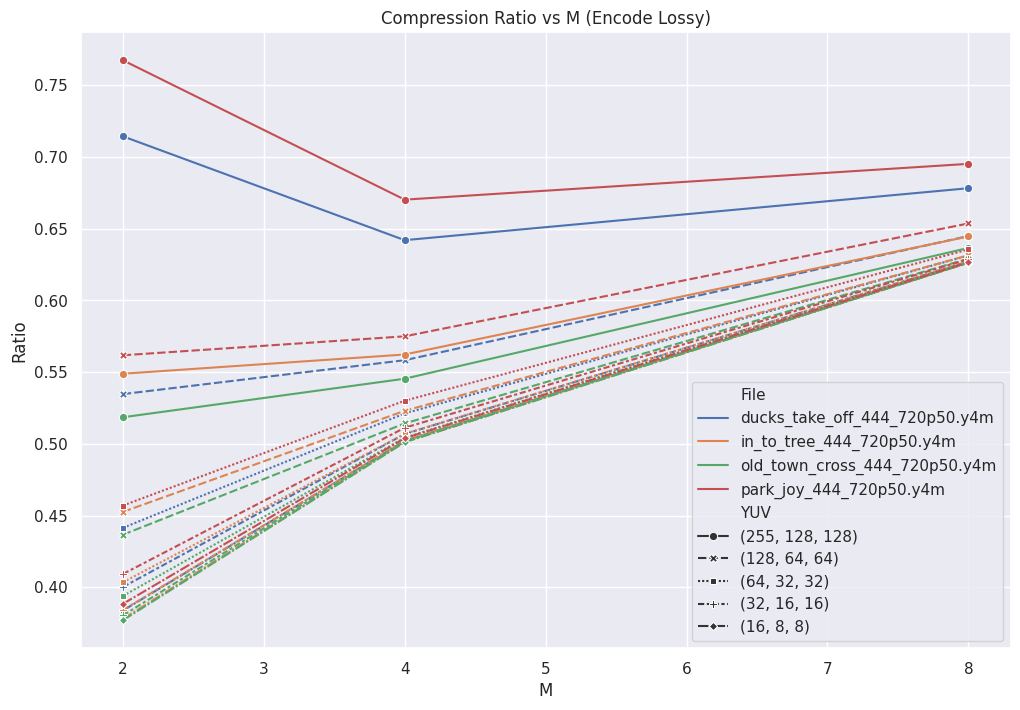

In [14]:
filtered = [result for result in results if result.operation == "encode" and pd.notna(result.yuv)]

original_size = [result.original_size for result in filtered]
compressed_size = [result.compressed for result in filtered]
ratio = [result.compressed / result.original_size for result in filtered]

df = pd.DataFrame(
    {
        "Ratio": ratio,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Ratio", hue="File", style="YUV", markers=True)
g.set_title("Compression Ratio vs M (Encode Lossy)")
g.set_ylabel("Ratio")
g.figure.savefig(folder + "compression_lossy.png")

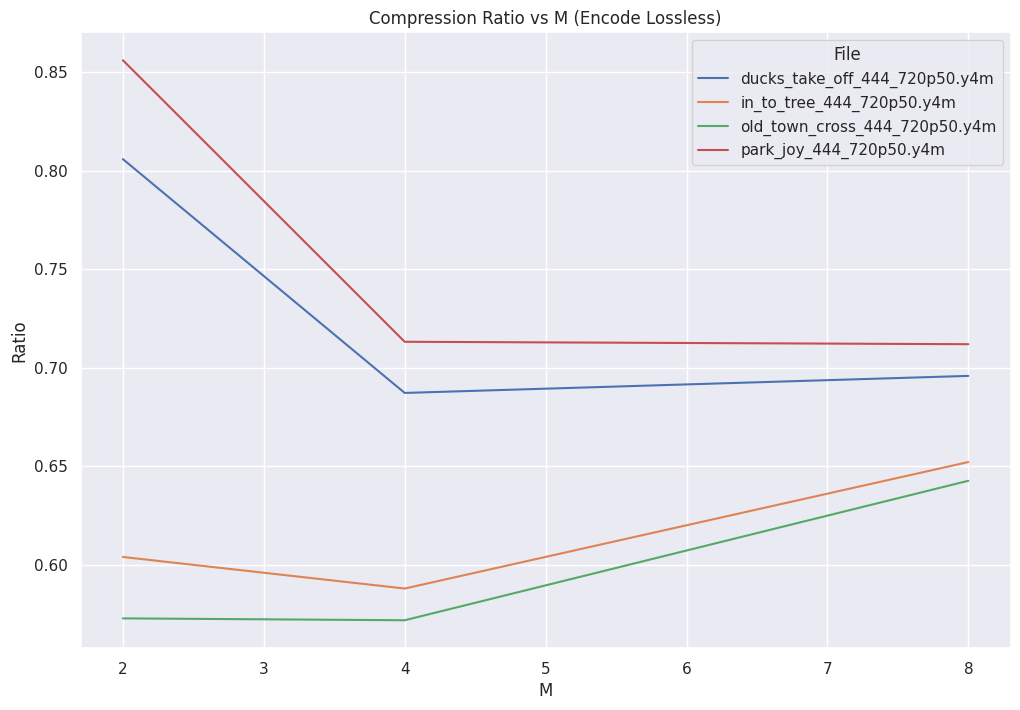

In [15]:
filtered = [result for result in results if result.operation == "encode" and pd.isna(result.yuv)]

original_size = [result.original_size for result in filtered]
compressed_size = [result.compressed for result in filtered]
ratio = [result.compressed / result.original_size for result in filtered]

df = pd.DataFrame(
    {
        "Ratio": ratio,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Ratio", hue="File", markers=True).set_title("Compression Ratio vs M (Encode Lossless)")
g.figure.savefig(folder + "compression_lossless.png")

In [16]:
filtered = [result for result in results if result.operation == "encode" and pd.notna(result.yuv)]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
scaled_time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": scaled_time_taken,
        "Time Taken": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

In [17]:
plt.title("Time Taken vs M (Encode Lossy)")
for i, file in enumerate(test_files):
  ax1 = plt.subplot()
  ax2 = ax1.twinx()
  ax2.grid(False)
  sns.lineplot(data=df[df["File"] == file], x="M", y="Time Taken (scaled)", hue="YUV", ax=ax1)
  sns.lineplot(data=df[df["File"] == file], x="M", y="Time Taken", hue="YUV", ax=ax2)
  ax1.set_title(file)
  plt.savefig(folder + "time_lossy_" + file.split("_")[0] + ".png")
  plt.clf()


<Figure size 1200x800 with 0 Axes>

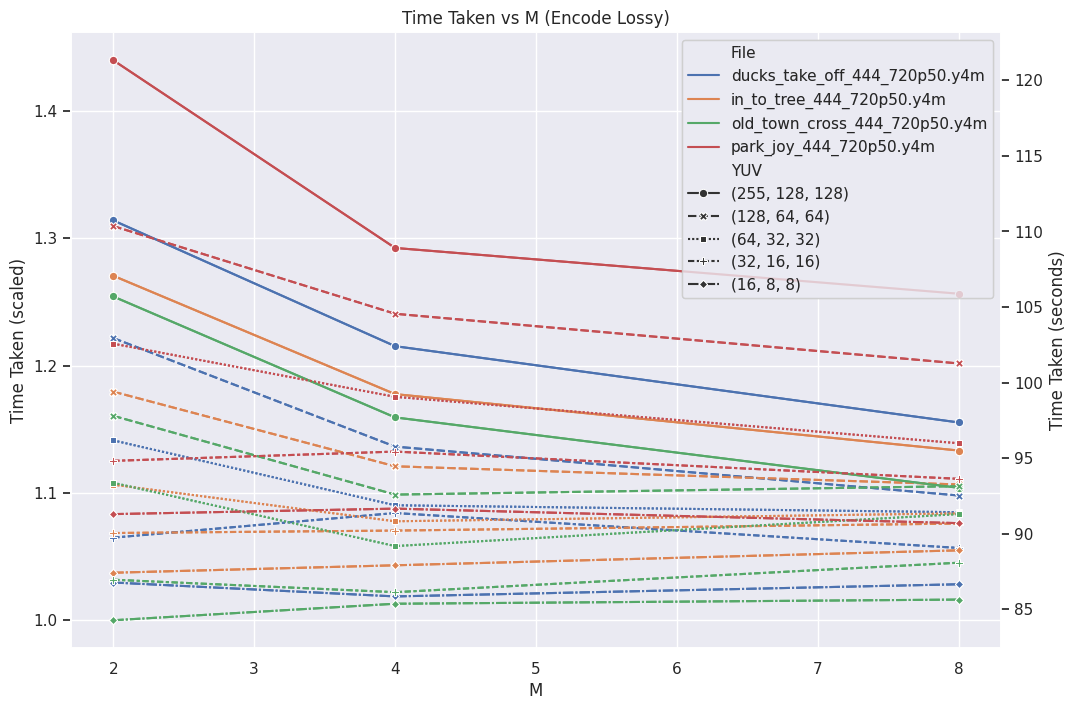

In [18]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax2.grid(False)

sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", style="YUV", markers=True, ax=ax1)
sns.lineplot(data=df, x="M", y="Time Taken", hue="File", style="YUV", markers=True, ax=ax2)

ax1.set_ylabel("Time Taken (scaled)")
ax2.set_ylabel("Time Taken (seconds)")

plt.title("Time Taken vs M (Encode Lossy)")
plt.savefig(folder + "time_lossy.png")

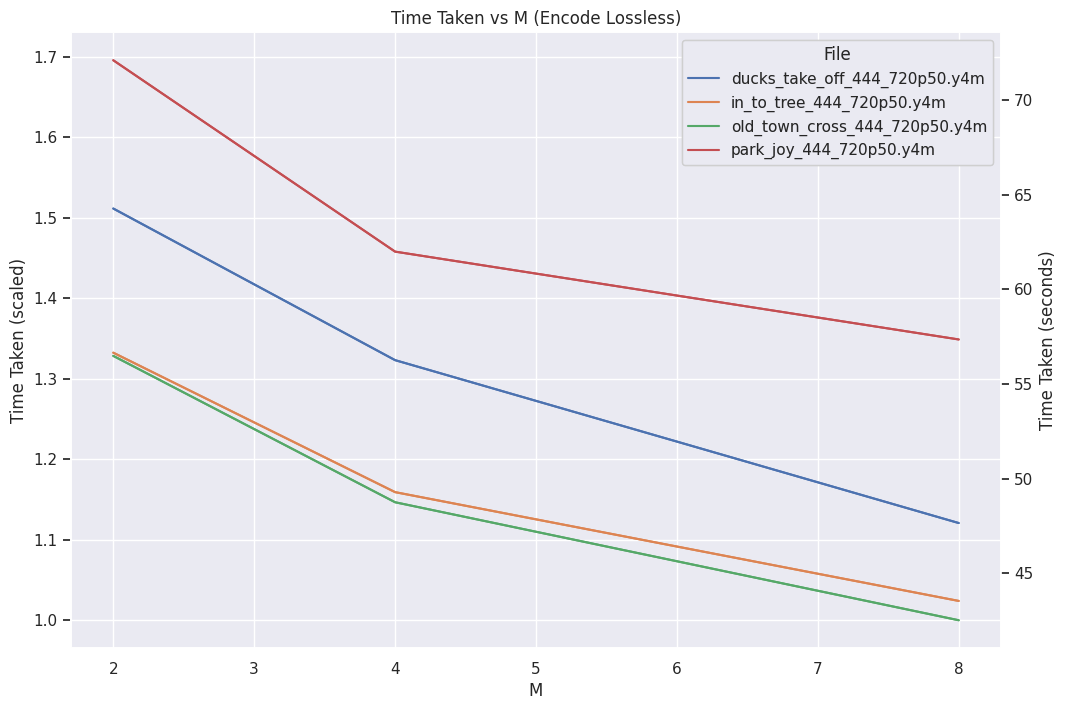

In [19]:
filtered = [result for result in results if result.operation == "encode" and pd.isna(result.yuv)]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
scaled_time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": scaled_time_taken,
        "Time Taken": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
    }
)

ax1 = plt.subplot()
ax2 = ax1.twinx()
ax2.grid(False)

sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", markers=True, ax=ax1)
sns.lineplot(data=df, x="M", y="Time Taken", hue="File", markers=True, ax=ax2)

ax1.set_ylabel("Time Taken (scaled)")
ax2.set_ylabel("Time Taken (seconds)")

plt.title("Time Taken vs M (Encode Lossless)")
plt.savefig(folder + "time_lossless.png")

In [20]:
filtered = [result for result in results if result.operation == "decode" and pd.notna(result.yuv)]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
scaled_time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": scaled_time_taken,
        "Time Taken": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

In [21]:
plt.title("Time Taken vs M (Decode Lossy)")
for i, file in enumerate(test_files):
  ax1 = plt.subplot()
  ax2 = ax1.twinx()
  ax2.grid(False)
  sns.lineplot(data=df[df["File"] == file], x="M", y="Time Taken (scaled)", hue="YUV", ax=ax1)
  sns.lineplot(data=df[df["File"] == file], x="M", y="Time Taken", hue="YUV", ax=ax2)
  ax1.set_title(file)
  plt.savefig(folder + "time_lossy_decode_" + file.split("_")[0] + ".png")
  plt.clf()

<Figure size 1200x800 with 0 Axes>

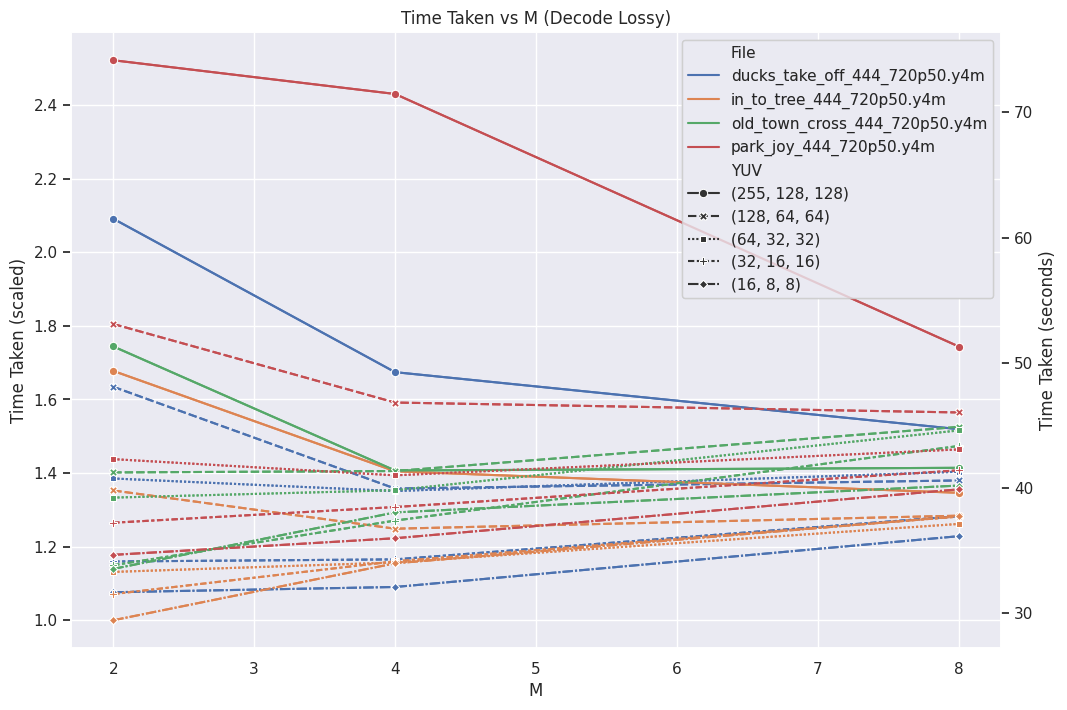

In [22]:


ax1 = plt.subplot()
ax2 = ax1.twinx()
ax2.grid(False)

sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", style="YUV", markers=True, ax=ax1)
sns.lineplot(data=df, x="M", y="Time Taken", hue="File", style="YUV", markers=True, ax=ax2)

ax1.set_ylabel("Time Taken (scaled)")
ax2.set_ylabel("Time Taken (seconds)")

plt.title("Time Taken vs M (Decode Lossy)")
plt.savefig(folder + "time_lossy_decode.png")

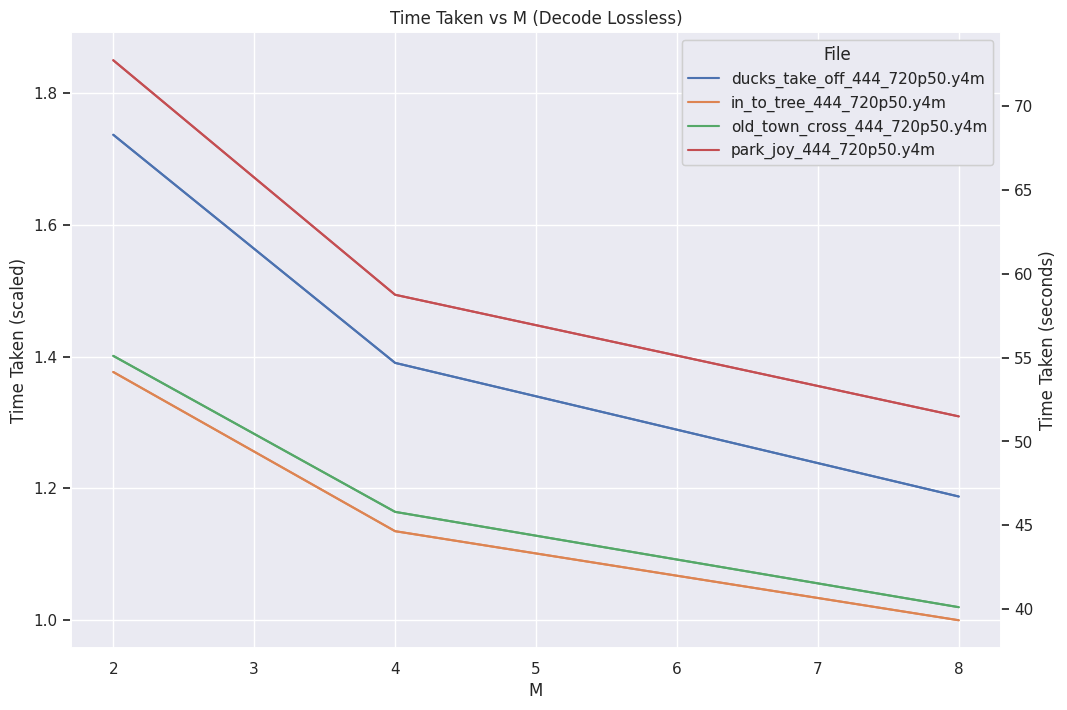

In [23]:
filtered = [result for result in results if result.operation == "decode" and pd.isna(result.yuv)]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
scaled_time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": scaled_time_taken,
        "Time Taken": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
    }
)

ax1 = plt.subplot()
ax2 = ax1.twinx()
ax2.grid(False)

sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", markers=True, ax=ax1)
sns.lineplot(data=df, x="M", y="Time Taken", hue="File", markers=True, ax=ax2)

ax1.set_ylabel("Time Taken (scaled)")
ax2.set_ylabel("Time Taken (seconds)")

plt.title("Time Taken vs M (Decode Lossless)")
plt.savefig(folder + "time_lossless_decode.png")

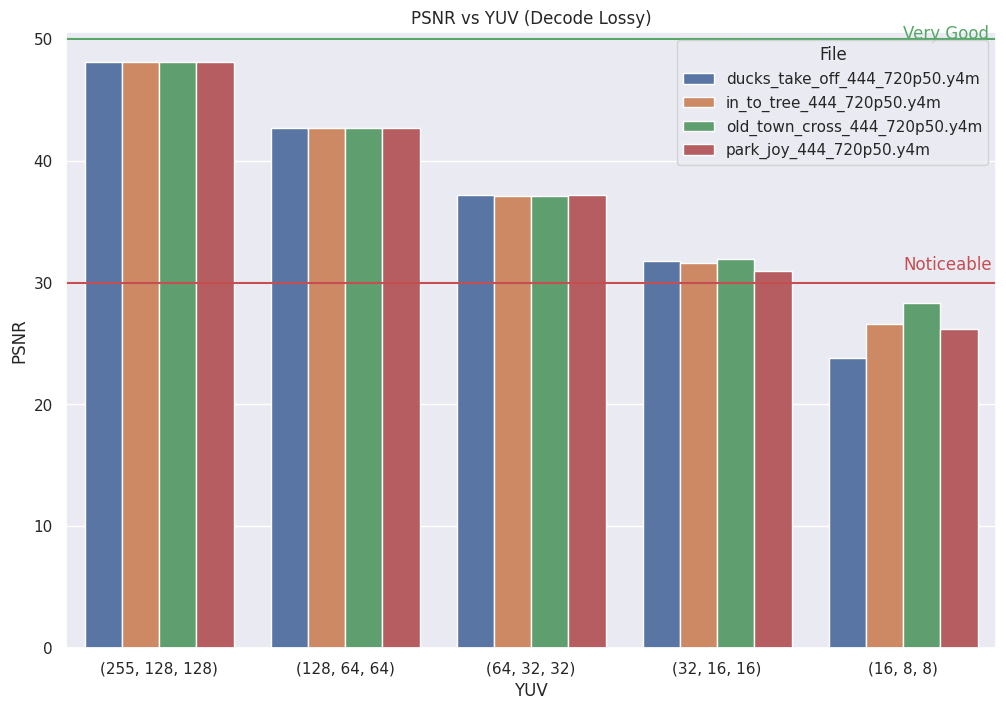

In [24]:
filtered = [result for result in results if result.operation == "decode" and pd.notna(result.yuv)]

df = pd.DataFrame(
    {
        "PSNR": [result.psnr for result in filtered],
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

ax1 = plt.subplot()

g = sns.barplot(data=df, x="YUV", y="PSNR", hue="File", ax=ax1)
g.set_title("PSNR vs YUV (Decode Lossy)")
plt.axhline(y=30, color='r')
plt.axhline(y=50, color='g')

# move upper annotations to the right
ax1.annotate('Noticeable', xy=(4, 31), xytext=(4, 31), color='r')
ax1.annotate('Very Good', xy=(4, 50), xytext=(4, 50), color='g')

g.figure.savefig(folder + "psnr.png")